# Derivation of the spectral density function from MD coordinate trajectories

## Theory 

Sub-µs motions of a protein determine the spectral density function (J($\omega$)), which describes the amount of motion at a given $\omega$ angular frequency. Despite its central role, the J($\omega$) cannot be fully accessed experimentally; rather, NMR observables such as η$_{xy}$, τ$_c$, R$_1$, R$_2$ and NOE are determined by the underlying J($\omega$) at particular frequencies, such that only certain points of the J($\omega$) can be mapped by combining multiple NMR measurements at different conditions [Abyzov et al. 2016](https://pubs.acs.org/doi/10.1021/jacs.6b02424). 
The very same motions can be described by the orientational auto correlation function C($\tau$) of the backbone amide-proton bond vector for every protein residue with the necassary atoms [Hoffmann et al. 2018](https://pubs.rsc.org/en/content/articlelanding/2018/cp/c8cp03915a) and [Camacho-Zarco et al. 2022](https://pubs.acs.org/doi/10.1021/acs.chemrev.1c01023).  

$ \large C(\tau) = < P_2(\vec{\mu}(0) · \vec{\mu}(\tau)) > $

where P$_2$(x) = (3x$^2$ − 1)/2 is the second order Legendre polynomial, $\vec{\mu(t)}$ is the unit vector of the H-N bond, and 〈 〉 denotes the average over all time differences $\tau$. In our particular case the following equation was used:

$ \large C(\tau) = < P_2(\cos\angle\left(\vec{\mu}(t),\vec{\mu}(t+\tau)\right) > $

Fourier transformation of the C($\tau$) yields the power spectral density of the bond orientation, hence allow the calculation of the spectral density function from MD coordinates at a range of frequencies determined by the frame rate of the trajectory (high frequency limit: 1/time step) and the length of the simulation (low frequency limit: 2/simulation time).

The SDF sampled at certain frequencies (0, $\omega_N$, $\omega_H$, $\omega_p$, $\omega_m$) allow the caluclation of different NMR observables such as η$_{xy}$, τ$_c$, R$_1$, R$_2$ and NOE [[Robson et al. 2022](https://link.springer.com/article/10.1007/s10858-021-00379-5)] 

## Spectral density function calculation

To load the atom coordinates for the calcualtion we use the python package pyemma.

In [9]:
import numpy as np
from pyemma.coordinates import featurizer, load
import numpy.linalg as LA
from scipy.fft import fft

# define functions to calculate the rotation autocorrelation 

# Legendre polinomial P2
def P2(x):
    return (3*x*x-1)/2

#rotation autocorrelation of 3D vector series of multiple residues
def rotacf_array(bond_vector,lag_frames = np.arange(0,1000)):
    """
    bond_vector is a N×M×3 array with dimensions: time, residue, xyz coordinates
    lag_frames is an array with the lag times in time step unit if the input data therefore an integer sequence.

    output is an array of lag_frames.size×M containing the ACF for all residues in the input
    """
    Cp = np.zeros((lag_frames.size,bond_vector.shape[1]))
    for i,lag in enumerate(lag_frames):
        if lag == 0: # at zero lag time, it should be 1
            pre = bond_vector
            post = bond_vector
            #inner product 
            inner = np.einsum('ijk,ijk->ij', pre, post)
            #length
            norms = LA.norm(pre,axis=2) * LA.norm(post,axis=2)
            #cosine
            cos = inner / norms
            #average
            Cp[i] = np.mean(P2(cos),axis=0)
            
        else:
            #get angle
            pre = bond_vector[:-lag,:]
            post = bond_vector[lag:,:]
            #inner product 
            inner = np.einsum('ijk,ijk->ij', pre, post)
            #length
            norms = LA.norm(pre,axis=2) * LA.norm(post,axis=2)
            #cosine
            cos = inner / norms
            #averaging over all possible time_lag pairs
            Cp[i,:] = np.mean(P2(cos),axis=0)
    return Cp 



In [2]:
#define input parameters

# topology of the input system, needs to be supported by pyemma
in_top = "../sample_data/topology.pdb"
# trajecotry of the input system, needs to be supported by pyemma
in_traj = "../sample_data/sample_traj.xtc"
# trajectory stride, integer
stride = 1
# number of frames used (after stride has been applied), integer
frame_number = 10000
# time difference between frames, a float in seconds
dt = 1e-10 # 100 ps
# the longest lag time in strided frame number 
max_lag = 1000 # 100 ns
#save the spectral density to a pickled numpy array *.npy
outfile = "../sample_data/test_spectral_density_output.npy"

#the sequence of the lag_times
lag_frames = np.arange(max_lag) #lag times in frames
# the frequencies of the Fourier transformed ACF, derived from the lag_times
freq = np.arange(max_lag) / (max_lag*dt) # Hz
# the Fourier transformed ACF needs to be normalized based on the length of the max lag_time. 
#The factor 0.4 origintes from the definition of the spectral density function (see eq. 9 in https://link.springer.com/article/10.1007/s10858-021-00379-5)
sdf_normalizer = 0.4*0.5*max_lag*dt



In [5]:
#read in corrdinates

#initialize featurizer
feat_N = featurizer(in_top)
feat_HN = featurizer(in_top)

#select all residues having backbone and and H
feat_N.add_selection(feat_N.select("not resname PRO and name N"))
feat_HN.add_selection(feat_HN.select("not resname PRO and name H"))

#residues are infered from the features
temp = [int(i.split()[1]) for i in feat_N.describe() ]
resi = np.array(list(set(temp)))

print(f"residues selected for analysis: {resi}")


residues selected for analysis: [ 1  2  3  5  6  7  9 10 11 14 15 16 17 18 19 20 21 22 23 24 25 26 28 29
 30 31 32 33 35 37 38 39 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 61 62 63 65 66 68 69 70 73]


In [7]:
#read in trajectory data
data_N = load(in_traj, features=feat_N,stride=1)
data_HN = load(in_traj, features=feat_HN,stride=1)
bond_vector = data_N[:frame_number] - data_HN[:frame_number]

#check the bond vector, it should be frames × residues*3 for the xyz coordinates
print(bond_vector.shape)

(10000, 177)


In [10]:
#Reshape to have a 3D input for easy differentiation of residues and vecotriaztion purposes: frames × residues × 3 for the xyz coordinates
bond_vector_reshaped = bond_vector.reshape((-1,resi.size,3))
#Normalize by length
bond_vector_length = np.sqrt(np.sum(bond_vector_reshaped**2,axis=2))
bond_vector_reshaped_normalized = bond_vector_reshaped / bond_vector_length[:,:,None]

#Calculate the ACF, it is an array with lag_times × residues
acf = rotacf_array(bond_vector_reshaped_normalized,lag_frames=lag_frames)

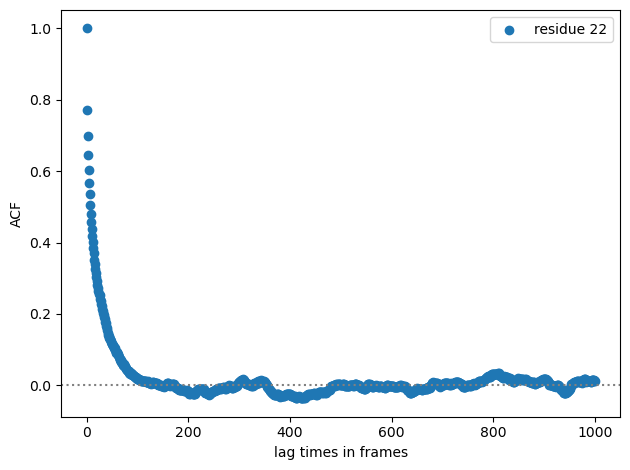

In [16]:
#Check an example how our ACF looks like
import matplotlib.pyplot as plt

plt.scatter(lag_frames, acf[:,17], label=f"residue {resi[17]}")
plt.xlabel("lag times in frames")
plt.ylabel("ACF")
plt.axhline(0,linestyle=":",color="grey")
plt.legend(loc="upper right")
plt.tight_layout()

In [21]:
# Fourier transform the ACF

#First we symmetrize the ACF by stacking a mirrored version to it
acf_symmetric = np.row_stack(([acf[:-1,:],np.flip(acf,axis=0)]))

#Calculate spectral density function and immediately normalize it with the ACF length
# the output is an array with frequencies × residues
# because the symmetry nature of the fft only the first 1000(=max lag in frames) values are used further
sdf = sdf_normalizer * np.real(fft(acf_symmetric,norm="forward",axis=0))
    
#save the result to a dictionary
to_save = {"resi":resi,
          "freq_Hz":freq,
          "dt":dt,
          "sdf_normalized":sdf[:freq.size]}

np.save(outfile,to_save,allow_pickle=True)

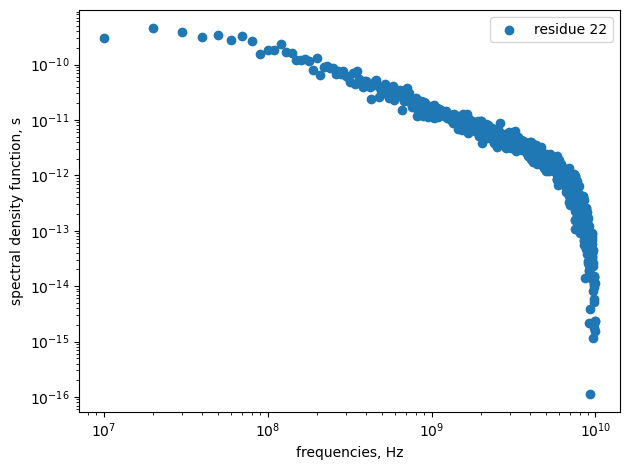

In [22]:
#Check an example how our spectral density function looks like
import matplotlib.pyplot as plt

plt.scatter(freq, sdf[:freq.size,17], label=f"residue {resi[17]}")
plt.xlabel("frequencies, Hz")
plt.ylabel("spectral density function, s")
plt.legend(loc="upper right")
plt.loglog()
plt.tight_layout()

## Derivation of different NMR observables from the spectral density function 

Using constants, experimental parameters and equations from [Robson et al. 2022](https://link.springer.com/article/10.1007/s10858-021-00379-5) many values measurable by NMR can be derived. These are using combinations of the spectral density function at certain frequencies: 0, $\omega_N$, $\omega_H$, $\omega_p$, $\omega_m$ which are dependent on the magnetic field strength of the experiment.

Given the field strength of B$_0$ =  28.189 T (corresponding to a Larmor frequency of 1200.236 MHz) and gyromagnetic ratios $\gamma_N = -27.1 MHz$ and $\gamma_H = 267.5 MHz$ 

$\omega_N = B_0 * \gamma_N$

$\omega_H = B_0 * \gamma_H$

$\omega_p = \omega_H + \omega_N $

$\omega_m = \omega_H - \omega_N $

all of them in angular frequency rad/s.

Special J($\omega$) values are obtained the following way:

In [25]:
# spectral density function values at certain frequencies.

#Experimental conditions and constants
Larmor_H = 1200.236 # MHz
B_0 = 28.189 # in Tesla

gamma_H = 267.52218744 * np.power(10,6, dtype=np.longdouble) # proton gyromagnetic ratio 
gamma_N = -27.116 * np.power(10,6, dtype=np.longdouble)      # 15N gyromagnetic ratio

#specal frequencies
w_N = B_0 * gamma_N  # 15N frequency (radians/s)
w_H = B_0 * gamma_H  # 1H frequency (radians/s)
w_p = w_H + w_N
w_m = w_H - w_N

#get values of the spectral density function at the nearest available frequency
#the following variables are 1D arrays corresponding to the different residues
J0 = sdf[0,:] # sdf at w=0 frequency
JwN = sdf[np.argmin((freq + w_N)**2),:] # w_N
JwH = sdf[np.argmin((freq - w_H)**2),:] # w_N
Jwp = sdf[np.argmin((freq - w_p)**2),:] # w_N
Jwm = sdf[np.argmin((freq - w_m)**2),:] # w_N


### Calculating η$_{xy}$

$ η_{xy} = p \delta_N (4J(0)+3J(\omega_N))(3cos^2\theta-1) $ where 

$ \theta =  17\pi / 180 $ angle between chemical shift anisotropy axis and NH bond 

$ p = \frac{\mu_0\gamma_H\gamma_N h}{16\pi^2\sqrt{2}r^3}$

$ \mu_0 = 1.25663706×10^{-6}   $ vacuum permeability 

$ h = 6.62607×10^{-34} $ Plank's constant

$ r = 1.02×10^{-10}  $ H-N bond length

$ \delta_N = \frac{\gamma_N B_0 \Delta\delta_N}{3\sqrt{2}}$  15N chemical shift anisotropy

$ \Delta\delta_N =  0.00016  $ axially symetric 15N chemical shift tensor

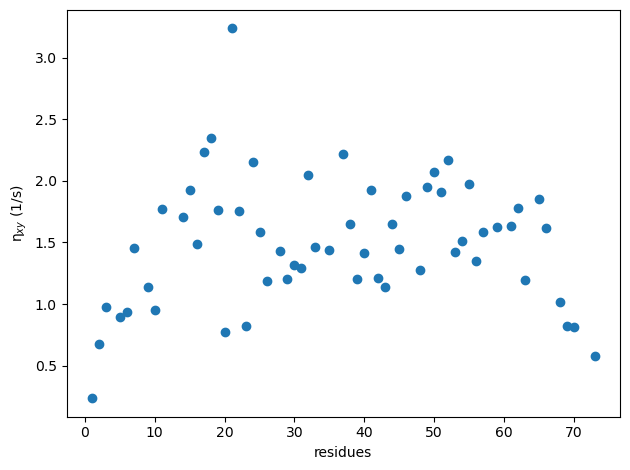

In [39]:
h = 6.62607004 * (1/np.power(10,34, dtype=np.longdouble))    # Plank's constant
mu_0 = 1.25663706 * (1/np.power(10,6, dtype=np.longdouble))  # vacuum permeability
gamma_H = 267.52218744 * np.power(10,6, dtype=np.longdouble) # proton gyromagnetic ratio
gamma_N = -27.116 * np.power(10,6, dtype=np.longdouble)      # 15N gyromagnetic ratio
r = 1.02 * (1/np.power(10,10, dtype=np.longdouble))          # internuclear distance
delta_dN = 160 * (1/np.power(10, 6))                         # difference in axially symetric 15N CS tensor
theta = 17*np.pi/180                                         # angle between CSA axis and NH bond

def eta_xy(J0,Jw_N):
    """
    Calculate the eta_xy from the given spectral density function values
    output is the same shape as the input arrays which needs to match
    """
    p = mu_0*gamma_H*gamma_N*h/(16*np.pi*np.pi*np.sqrt(2)*np.power(r,3))
    dN = gamma_N*B_0*delta_dN/(3*np.sqrt(2)) 

    return p*dN*(4*J0 + 3*Jw_N)*(3*np.cos(theta)*np.cos(theta)-1)

plt.scatter(resi,eta_xy(J0,JwN))
plt.xlabel("residues")
plt.ylabel("η$_{xy}$ (1/s)")
plt.tight_layout()

### τ$_c$ derived from η$_{xy}$

The τ$_c$ or tumbling time scale is calculated using the η$_{xy}$ with the following equation:

$ \large τ_c =  \frac{5 c}{24} - \frac{336  \omega_N^2 - 25 c^2  \omega_N^4} {24 \omega_N^2 (1800  c  \omega_N^4 + 125 c^3 \omega_N^6 + 24  \sqrt{3} \sqrt{21952 \omega_N^6 - 3025 c^2 \omega_N^8 + 625 c^4 \omega_N^10})^{\frac{1}{3}}}  +   
\frac{(1800 c  \omega_N^4 + 125 c^3  \omega_N^6 + 24 \sqrt{3} \sqrt{21952 \omega_N^6
            - 3025 c^2  \omega_N^8 + 625  c^4 \omega_N^10})^{\frac{1}{3}}} { 24 \omega_N^2}     $ where 

$ \large c = \frac{ η_{xy}}{p \delta_N (3 cos^2 \theta - 1) } $

The rest of the parameters are as defined above. Accodingly the function for tau is the following:

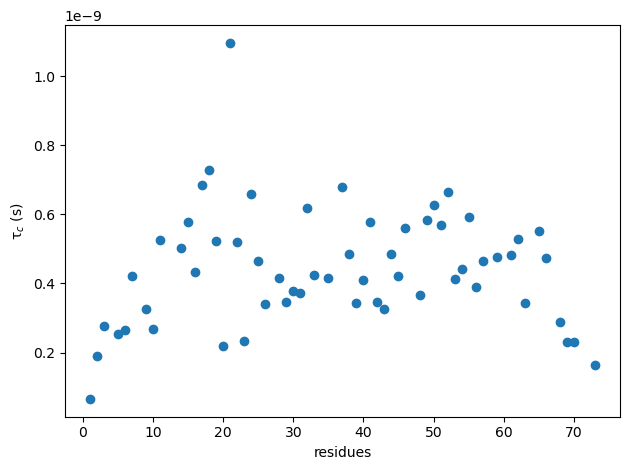

In [42]:
def tau_from_eta(eta):
    """
    Calculate the tau_c from eta_xy 
    output is the same shape as the input 
    """
    p = mu_0*gamma_H*gamma_N*h/(16*np.pi*np.pi*np.sqrt(2)*np.power(r,3))
    dN = gamma_N*B_0*delta_dN/(3*np.sqrt(2)) 
    c = eta / (dN * p * (3 * np.cos(theta) ** 2 - 1))
    t1 = (5 * c) / 24
    t2 = (336 * (w_N ** 2) - 25 * (c ** 2) * (w_N ** 4)) / (24 * (w_N ** 2) * (1800 * c * (w_N ** 4) + 125 * (c ** 3) * (w_N ** 6)
            + 24 * np.sqrt(3) * np.sqrt(21952 * (w_N ** 6)-3025 * (c ** 2) * (w_N ** 8)
                + 625 * (c ** 4) * (w_N ** 10)))**(1 / 3))
    t3 = (1800 * c * (w_N ** 4) + 125 * (c ** 3) * (w_N ** 6)+ 24 * np.sqrt(3) * np.sqrt(21952 * (w_N ** 6)
            - 3025 * (c ** 2) * (w_N ** 8) + 625 * (c ** 4) * (w_N ** 10))) ** (1 / 3) / (24 * w_N ** 2)

    return t1 - t2 + t3

plt.scatter(resi,tau_from_eta(eta_xy(J0,JwN)))
plt.xlabel("residues")
plt.ylabel("τ$_c$ (s)")
plt.tight_layout()

### R$_2$

The R$_2$ is dependent on J($\omega$) values on a wide range of frequencies. Protone relaxation is quntified by the following equation:

$ R_2 = \frac{d}{8} (4 J(0) + 3 J(\omega_H) + J(\omega_m) + 6 J(\omega_N) + 6 J(\omega_p)) + \frac{1}{6} c \omega_H^2 (4 J(0) + 3 J(\omega_H)) $ where

$ c = \frac{\Delta\delta H^2}{3}  $

$ \Delta\delta H = 10^{-5} $ and is the difference in the axially symetric proton chemical shift tensor

$ d = (\frac{\mu_0}{(4\pi)})^2 (\frac{h}{2\pi})^2 \gamma_H^2 \gamma_N^2 r^{-6} $  the N-H dipole contribution

The rest of the parameters are as defined above. Accodingly the function for R$_2$ is the following:

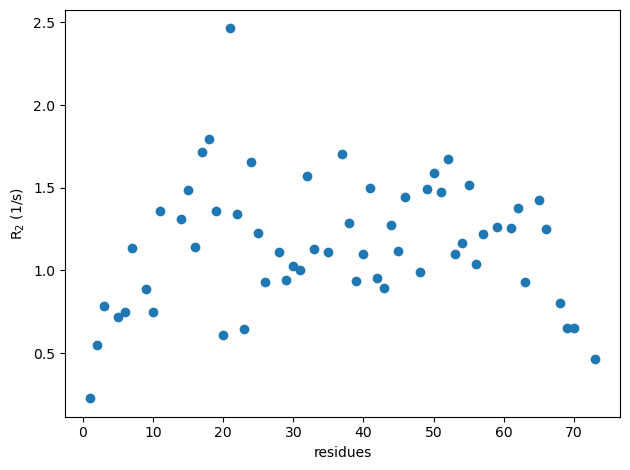

In [45]:
def R2(J0,Jw_N,Jw_H,Jw_p,Jw_m):
    """
    Calculate the R2 from the given spectral density function values
    output is the same shape as the input arrays which needs to match
    """
    delta_dH = 10 * (1 / np.power(10, 6)) # difference in axially symetric 1H CS tensor
    c = (delta_dH**2)/3.0
    d = (mu_0/(4*np.pi))**2 * (h/(2*np.pi))**2 * gamma_H**2 * gamma_N**2 * (r**-6)  # N-H Dipole contribution
    return (d/8)*(4*J0 + 3*Jw_H + Jw_m + 6*Jw_N + 6*Jw_p) + (1/6)*c*(w_H**2)*(4*J0 + 3*Jw_H)

plt.scatter(resi,R2(J0,JwN,JwH,Jwp,Jwm))
plt.xlabel("residues")
plt.ylabel("R$_2$ (1/s)")
plt.tight_layout()

### R$_1$ 

R$_1$ is derived the following way:

$ R_1 = \frac{d^2}{4}  (3 J(\omega_N) + J(\omega_m) + 6 J(\omega_p)) + c^2 J(\omega_N) $ where 

$ c = \frac{ \omega_N \Delta\delta_N }{\sqrt{3}} $

$ d = \frac{\mu_0 \gamma_H  \gamma_N  h}{8  \pi^2 r^3} $ 

The rest of the parameters are as defined above. Accodingly the function for R$_1$ is the following:

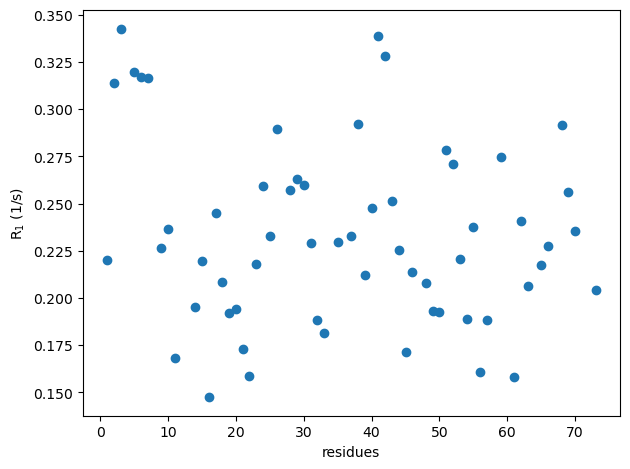

In [51]:
def R1(Jw_N,Jw_p,Jw_m):
    """
    Calculate the R1 from the given spectral density function values
    output is the same shape as the input arrays which needs to match
    """
    c = (w_N * delta_dN) / (np.sqrt(3))
    d = (mu_0 * gamma_H * gamma_N * h) / (8 * np.pi * np.pi * r * r * r) # from Palmer
    return (d*d/4)*(3*Jw_N + Jw_m + 6*Jw_p) + c * c * Jw_N

plt.scatter(resi,R1(JwN,Jwp,Jwm))
plt.xlabel("residues")
plt.ylabel("R$_1$ (1/s)")
plt.tight_layout()

### NOE

Calculation of the NOE require the R1 and uses the same d parametere as we used for R1.

$ NOE = 1 + \frac{d^2 \gamma_H}{4  \gamma_N} (6 J(\omega_p) - J(\omega_m)) \frac{1}{R_1} $


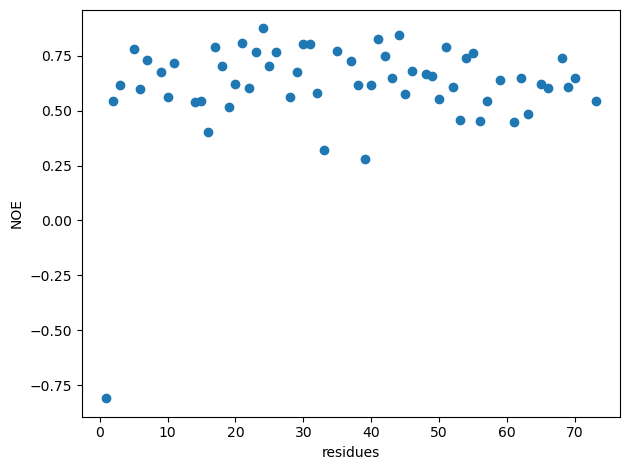

In [53]:
def noe(Jw_N,Jw_p,Jw_m):
    """
    Calculate the NOE from the given spectral density function values
    As an intermediate requirement R1 is also calculated.
    output is the same shape as the input arrays which needs to match
    """
    d = (mu_0 * gamma_H * gamma_N * h) / (8 * np.pi * np.pi * r * r * r) 
    c = (gamma_N * B_0 * delta_dN) / (np.sqrt(3))
    R1 = (d*d/4)*(3*Jw_N + Jw_m + 6*Jw_p) + c * c * Jw_N
    noe = 1 + (d*d*gamma_H / (4 * gamma_N)) * (6*Jw_p - Jw_m) * (1 / R1)
    return noe 

plt.scatter(resi,noe(JwN,Jwp,Jwm))
plt.xlabel("residues")
plt.ylabel("NOE")
plt.tight_layout()